In [206]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import torch
import random
import numpy as np
import gc

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

gc.collect()
torch.cuda.empty_cache()

# ENSEMBLE METHODS

In [207]:
# ==================== ENSEMBLE METHODS ====================
import torch
import torch.nn as nn

class StackingEnsemble(nn.Module):
    """
    Stacking Ensemble: Meta-learner học cách combine predictions
    Thay vì fixed weights, học weights dựa trên input features
    """
    def __init__(self, models, hidden_dim=64, freeze_base=True):
        super().__init__()
        self.models = nn.ModuleList(models)
        self.n_models = len(models)
        
        # Freeze base models
        if freeze_base:
            for model in self.models:
                for param in model.parameters():
                    param.requires_grad = False
            for m in self.models:
                m.eval()  # chuyển base models sang eval
        
        # Meta-learner: học từ predictions của các models
        # Input: n_models predictions concatenated
        self.meta_learner = nn.Sequential(
            nn.Conv2d(self.n_models, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, 1, kernel_size=1),
            nn.Softplus()
        )
    
    def forward(self, x):
        # Get predictions from all models
        preds = []
        with torch.no_grad():
            for model in self.models:
                pred = model(x)  # (B, 1, H, W)
                preds.append(pred)
        
        # Stack predictions: (B, n_models, H, W)
        stacked = torch.cat(preds, dim=1)
        
        # Meta-learner combines them
        out = self.meta_learner(stacked)
        return out


class AttentionEnsemble(nn.Module):
    """
    Attention-based Ensemble: Học attention weights cho mỗi pixel
    Weights khác nhau cho từng vùng của image
    """
    def __init__(self, models, in_channels=12, freeze_base=True):
        super().__init__()
        self.models = nn.ModuleList(models)
        self.n_models = len(models)
        
        if freeze_base:
            for model in self.models:
                for param in model.parameters():
                    param.requires_grad = False
            for m in self.models:
                m.eval()  # chuyển base models sang eval
        
        # Attention network: từ input X, predict weights cho mỗi model tại mỗi pixel
        self.attention_net = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, self.n_models, kernel_size=1),  # Output: weights for each model
        )
    
    def forward(self, x):
        # Get predictions from all models
        preds = []
        with torch.no_grad():
            for model in self.models:
                pred = model(x)
                preds.append(pred)
        
        # Stack: (B, n_models, H, W)
        stacked = torch.cat(preds, dim=1)
        
        # Compute attention weights from input
        weights = self.attention_net(x)  # (B, n_models, H, W)
        weights = F.softmax(weights, dim=1)  # Normalize across models
        
        # Weighted sum
        out = (stacked * weights).sum(dim=1, keepdim=True)
        return out


class GatingEnsemble(nn.Module):
    """
    Gating Network Ensemble: Chọn model tốt nhất cho từng region
    Giống Mixture of Experts
    """
    def __init__(self, models, in_channels=12, freeze_base=True):
        super().__init__()
        self.models = nn.ModuleList(models)
        self.n_models = len(models)
        
        if freeze_base:
            for model in self.models:
                for param in model.parameters():
                    param.requires_grad = False
            for m in self.models:
                m.eval()  # chuyển base models sang eval
        
        # Gating network with global context
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),  # Global pooling
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, self.n_models),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        B = x.size(0)
        
        # Get predictions
        preds = []
        with torch.no_grad():
            for model in self.models:
                pred = model(x)
                preds.append(pred)
        
        # Stack: (B, n_models, 1, H, W)
        stacked = torch.stack(preds, dim=1)
        
        # Gate weights: (B, n_models)
        gate_weights = self.gate(x)
        
        # Expand for broadcasting: (B, n_models, 1, 1, 1)
        gate_weights = gate_weights.view(B, self.n_models, 1, 1, 1)
        
        # Weighted sum: (B, 1, H, W)
        out = (stacked * gate_weights).sum(dim=1)
        return out


class UncertaintyEnsemble(nn.Module):
    """
    Uncertainty-weighted Ensemble: Weight inversely proportional to prediction variance
    Model nào confident hơn (variance thấp) sẽ được weight cao hơn
    """
    def __init__(self, models, freeze_base=True):
        super().__init__()
        self.models = nn.ModuleList(models)
        self.n_models = len(models)
        
        if freeze_base:
            for model in self.models:
                for param in model.parameters():
                    param.requires_grad = False
            for m in self.models:
                m.eval()  # chuyển base models sang eval
        
        # Learnable temperature for softmax
        self.temperature = nn.Parameter(torch.ones(1))
    
    def forward(self, x):
        # Get predictions
        preds = []
        for model in self.models:
            with torch.no_grad():
                pred = model(x)
            preds.append(pred)
        
        # Stack: (B, n_models, H, W)
        stacked = torch.cat(preds, dim=1)
        
        # Compute variance across models at each pixel
        mean_pred = stacked.mean(dim=1, keepdim=True)
        variance = ((stacked - mean_pred) ** 2).mean(dim=1, keepdim=True)
        
        # Weights inversely proportional to variance
        # Model predictions close to mean get higher weight
        diff_from_mean = (stacked - mean_pred) ** 2
        weights = F.softmax(-diff_from_mean / (self.temperature + 1e-6), dim=1)
        
        # Weighted average
        out = (stacked * weights).sum(dim=1, keepdim=True)
        return out


class LearnedWeightEnsemble(nn.Module):
    """
    Simple Learned Weights: Học global weights cho mỗi model
    Đơn giản nhưng hiệu quả hơn fixed weights
    """
    def __init__(self, models, freeze_base=True):
        super().__init__()
        self.models = nn.ModuleList(models)
        self.n_models = len(models)
        
        if freeze_base:
            for model in self.models:
                for param in model.parameters():
                    param.requires_grad = False
        
        # Learnable weights (initialized uniform)
        self.weights = nn.Parameter(torch.ones(self.n_models) / self.n_models)
        
        # Optional: learnable bias and scale
        self.bias = nn.Parameter(torch.zeros(1))
        self.scale = nn.Parameter(torch.ones(1))
    
    def forward(self, x):
        preds = []
        with torch.no_grad():
            for model in self.models:
                pred = model(x)
                preds.append(pred)
        
        # Normalize weights
        weights = F.softmax(self.weights, dim=0)
        
        # Weighted sum
        out = sum(w * p for w, p in zip(weights, preds))
        
        # Scale and bias
        out = out * self.scale + self.bias
        
        return out
    
    def get_weights(self):
        """Return normalized weights for inspection"""
        return F.softmax(self.weights, dim=0).detach().cpu().numpy()

# mlp


In [208]:
import torch
import torch.nn as nn

def positional_encoding_2d(H, W, device='cpu'):
    pos = torch.zeros(H*W, 2).to(device)
    idx = 0
    for i in range(H):
        for j in range(W):
            pos[idx] = torch.tensor([i / H, j / W])
            idx += 1
    return pos  # shape (H*W, 2)

class MLP(nn.Module):
    def __init__(
        self, 
        H=21, W=34, C=12, 
        dim=256, depth=4,
        mask=None,
        dropout=0.0
    ):
        super().__init__()

        self.H = H
        self.W = W
        self.C = C

        # ---- 1) Mask ----
        if mask is None:
            mask = torch.ones(H, W, dtype=torch.bool)

        flat_mask = mask.view(-1)
        self.register_buffer("flat_mask", flat_mask)
        self.register_buffer("keep_idx", flat_mask.nonzero(as_tuple=True)[0])

        self.Nkeep = len(self.keep_idx)

        # ---- Positional encoding ----
        full_pos = positional_encoding_2d(H, W)
        self.register_buffer("pos", full_pos)

        # ---- Input projection ----
        self.in_proj = nn.Linear(C + 2, dim)
        self.in_dropout = nn.Dropout(dropout)

        # ---- Build MLP layers ----
        layers = []
        for _ in range(depth):
            layers.append(nn.Linear(dim, dim))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        self.mlp = nn.Sequential(*layers)

        # ---- Output projection ----
        self.out_proj = nn.Linear(dim, 1)
        self.out_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B = x.size(0)

        # Flatten → (B, 714, C)
        x = x.view(B, self.C, self.H * self.W).permute(0, 2, 1)

        # Positional encoding
        pos = self.pos.unsqueeze(0).expand(B, -1, -1)
        x = torch.cat([x, pos], dim=-1)

        # Keep only masked tokens
        x = x[:, self.keep_idx, :]   # (B, Nkeep, C+2)

        # Input projection
        x = self.in_proj(x)
        x = self.in_dropout(x)

        # MLP layers
        x = self.mlp(x)

        # Output layer
        x = self.out_proj(x)
        x = self.out_dropout(x)

        # Scatter back to full grid
        out = torch.zeros(B, self.H * self.W, 1, device=x.device)
        out[:, self.keep_idx] = x

        return out.view(B, 1, self.H, self.W)

# transformer

In [209]:
import torch
import torch.nn as nn

def positional_encoding_2d_sincos(H, W, dim, device="cpu"):
    """
    Trả về PE shape: (H*W, dim)
    dim phải là số chẵn
    """
    assert dim % 2 == 0, "dim phải là số chẵn cho sin-cos PE"

    pe = torch.zeros(H, W, dim, device=device)

    dim_h = dim // 2
    dim_w = dim // 2

    div_term_h = torch.exp(
        torch.arange(0, dim_h, 2, device=device) *
        (-math.log(10000.0) / dim_h)
    )
    div_term_w = torch.exp(
        torch.arange(0, dim_w, 2, device=device) *
        (-math.log(10000.0) / dim_w)
    )

    pos_h = torch.arange(H, device=device).unsqueeze(1)
    pos_w = torch.arange(W, device=device).unsqueeze(1)

    pe_h = torch.zeros(H, dim_h, device=device)
    pe_w = torch.zeros(W, dim_w, device=device)

    pe_h[:, 0::2] = torch.sin(pos_h * div_term_h)
    pe_h[:, 1::2] = torch.cos(pos_h * div_term_h)

    pe_w[:, 0::2] = torch.sin(pos_w * div_term_w)
    pe_w[:, 1::2] = torch.cos(pos_w * div_term_w)

    pe[:, :, :dim_h] = pe_h[:, None, :]
    pe[:, :, dim_h:] = pe_w[None, :, :]

    return pe.view(H * W, dim)

class Transformer(nn.Module):
    def __init__(
        self, 
        H=34, W=42, C=12, 
        dim=128, depth=4, heads=4, 
        mask=None,
        dropout=0.0,
        pos_dim=32        # <-- PE dimension
    ):
        super().__init__()

        self.H = H
        self.W = W
        self.C = C
        self.pos_dim = pos_dim

        # ---- 1) Fixed mask ----
        if mask is None:
            mask = torch.ones(H, W, dtype=torch.bool)

        flat_mask = mask.view(-1)
        self.register_buffer("flat_mask", flat_mask)
        self.register_buffer("keep_idx", flat_mask.nonzero(as_tuple=True)[0])
        self.Nkeep = len(self.keep_idx)

        # ---- 2) Sin-Cos Positional Encoding ----
        full_pos = positional_encoding_2d_sincos(H, W, pos_dim)
        self.register_buffer("pos", full_pos)

        # ---- 3) Input projection ----
        self.in_proj = nn.Linear(C + pos_dim, dim)
        self.in_dropout = nn.Dropout(dropout)

        # ---- 4) Transformer Encoder ----
        enc_layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=heads,
            dim_feedforward=dim * 4,
            batch_first=True,
            dropout=dropout,
            activation="relu",
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=depth)

        # ---- 5) Output ----
        self.out_proj = nn.Linear(dim, 1)
        self.out_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B = x.size(0)

        # (B, C, H, W) → (B, H*W, C)
        x = x.view(B, self.C, self.H * self.W).permute(0, 2, 1)

        # Add PE
        pos = self.pos.unsqueeze(0).expand(B, -1, -1)
        x = torch.cat([x, pos], dim=-1)

        # Mask tokens
        x = x[:, self.keep_idx, :]

        # Projection
        x = self.in_proj(x)
        x = self.in_dropout(x)

        # Transformer
        x = self.encoder(x)

        # Output
        x = self.out_proj(x)
        x = self.out_dropout(x)

        # Scatter back
        out = torch.zeros(B, self.H * self.W, 1, device=x.device)
        out[:, self.keep_idx] = x

        return out.view(B, 1, self.H, self.W)

# unet

In [210]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return F.softplus(self.conv(x))

In [211]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Unet(nn.Module):

    def __init__(self, n_channels, n_classes, bilinear=False):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# cnn

In [212]:
class CNN(nn.Module):

    def __init__(self, in_channels=12, base_filters=32):
        super(CNN, self).__init__()

        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, base_filters, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True),

            # Block 2
            nn.Conv2d(base_filters, base_filters * 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base_filters * 2),
            nn.ReLU(inplace=True),

            # Block 3
            nn.Conv2d(base_filters * 2, base_filters * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters * 4, base_filters * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters * 4),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(base_filters * 4, base_filters * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters * 2),
            nn.ReLU(inplace=True),

            nn.Conv2d(base_filters * 2, base_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True),

            nn.Conv2d(base_filters, 1, kernel_size=1)
        )

    def forward(self, x):
        # Bỏ dimension thừa nếu có
        if x.dim() == 5:
            x = x.squeeze(1)
        
        original_size = (x.shape[2], x.shape[3])  # (21, 34)
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        rainfall = F.interpolate(decoded, size=original_size, mode='bilinear', align_corners=False)
        
        return rainfall

# loss

In [213]:
import torch
import torch.nn as nn


class RainfallLoss(nn.Module):
    def __init__(self, mask, mse_weight=0.7, mae_weight=0.3):
        super().__init__()
        self.register_buffer('mask', mask)
        self.mse_weight = mse_weight
        self.mae_weight = mae_weight
        
        if self.mask.sum() == 0:
            raise ValueError("ERROR: Mask has 0 valid pixels!")
        
        print(f"\nRainfallLoss initialized:")
        print(f"  Valid pixels: {self.mask.sum():.0f}")
        print(f"  MSE weight: {self.mse_weight}, MAE weight: {self.mae_weight}")
        
    def forward(self, pred, target):
        # Safety check
        if torch.isnan(pred).any():
            print("⚠️  NaN in predictions!")
            pred = torch.nan_to_num(pred, nan=0.0)
        if torch.isnan(target).any():
            print("⚠️  NaN in targets!")
            target = torch.nan_to_num(target, nan=0.0)
        
        # Expand mask: (H,W) -> (B,H,W)
        mask_expanded = self.mask.unsqueeze(0).expand_as(pred)
        
        # Apply mask
        pred_masked = pred * mask_expanded
        target_masked = target * mask_expanded
        
        # Calculate loss - chia cho tổng số valid pixels trong batch
        batch_size = pred.size(0)

        weights = torch.where(target_masked > 0, torch.tensor(10.0, device=pred.device), torch.tensor(1.0, device=pred.device)) * mask_expanded
        # print(target_masked.shape)
        # print(sum((target_masked[0].flatten() > 0)))
        # print(sum((target_masked[0].flatten() == 0)))

        total_weight = weights.sum()
        
        mse = ((pred_masked - target_masked) ** 2 * weights).sum() / total_weight
        mae = (torch.abs(pred_masked - target_masked) * weights).sum() / total_weight
        
        loss = self.mse_weight * mse + self.mae_weight * mae
        
        # Final safety check
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"⚠️  NaN/Inf in loss! MSE={mse.item():.4f}, MAE={mae.item():.4f}")
            return torch.tensor(0.0, device=pred.device, requires_grad=True)
        
        return loss
    

In [214]:

from torch.utils.data import Dataset
import random

class RainDataset(Dataset):
    def __init__(self, X, Y, augmentation=False):
        """
        X: Tensor (N, C, H, W)
        Y: Tensor (N, H, W)
        augmentation: True/False
        """
        assert len(X) == len(Y), "X và Y phải cùng số lượng sample"

        self.X = X
        self.Y = Y
        self.aug = augmentation

    def __len__(self):
        return len(self.X)

    def augment(self, x, y):
        """
        x: (C, H, W)
        y: (H, W)
        """

        # --- Flip theo chiều H (vertical) ---
        if random.random() < 0.5:
            x = torch.flip(x, dims=[1])   # H: dim=1
            y = torch.flip(y, dims=[0])   # H: dim=0

        # --- Flip theo chiều W (horizontal) ---
        if random.random() < 0.5:
            x = torch.flip(x, dims=[2])   # W: dim=2
            y = torch.flip(y, dims=[1])   # W: dim=1

        # --- Rotate 180° (an toàn, giữ nguyên shape) ---
        if random.random() < 0.3:
            x = torch.rot90(x, k=2, dims=[1, 2])  # xoay theo H,W
            y = torch.rot90(y, k=2, dims=[0, 1])

        # --- Gaussian noise ---
        if random.random() < 0.3:
            x = x + torch.randn_like(x) * 0.01

        return x, y

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]

        # shape Y đang là (H, W) → thêm channel 1 nếu bạn muốn
        # nhưng bạn nói dataset là (N, H, W) nên để nguyên

        if self.aug:
            x, y = self.augment(x, y)

        return x, y

# LR

In [215]:
# learning_rate_schedule.py
import math
import torch

class MyScheduler(torch.optim.lr_scheduler.LRScheduler):
    """
    Warmup theo ratio + step-based decay (linear, cosine, exponential)
    Đảm bảo LR cuối cùng = base_lr * final_lr_ratio chính xác.
    """
    def __init__(self, optimizer, total_steps, warmup_ratio=0.1,
                 scheduler_type="cosine", gamma=0.1, final_lr_ratio=0.1, last_epoch=-1):

        self.scheduler_type = scheduler_type.lower()
        self.gamma = gamma
        self.warmup_steps = max(1, int(total_steps * warmup_ratio))
        self.total_steps = total_steps
        self.final_lr_ratio = final_lr_ratio

        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch + 1
        lrs = []

        for base_lr in self.base_lrs:
            final_lr = base_lr * self.final_lr_ratio

            # ----------------
            # 1. Warmup phase
            # ----------------
            if step <= self.warmup_steps:
                lr = base_lr * step / self.warmup_steps
                lrs.append(lr)
                continue

            # ----------------
            # 2. Decay phase
            # ----------------
            decay_step = step - self.warmup_steps
            decay_total = self.total_steps - self.warmup_steps
            t = decay_step / decay_total  # normalized: 0 → 1

            if self.scheduler_type == "linear":
                # linear decay từ base_lr → final_lr
                lr = base_lr + (final_lr - base_lr) * t

            elif self.scheduler_type == "cosine":
                # cosine, nhưng scale để cuối = final_lr
                cosine = 0.5 * (1 + math.cos(math.pi * t))
                # scale để cosine(0)=1, cosine(1)=final_lr/base_lr
                lr = final_lr + (base_lr - final_lr) * cosine

            elif self.scheduler_type == "exponential":
                # exponential thật sự luôn giảm đúng từ base_lr → final_lr
                # base_lr * k^(decay_total) = final_lr  => k = (final_lr/base_lr)^(1/decay_total)
                k = (final_lr / base_lr) ** (1 / decay_total)
                lr = base_lr * (k ** decay_step)

            else:
                raise ValueError(f"Scheduler type {self.scheduler_type} not supported")

            lrs.append(lr)

        return lrs

    def step(self, epoch=None):
        super().step(epoch)

# ===========================
# Example usage
# ===========================


# path

In [216]:
import numpy as np
from scipy import ndimage

def fill_nodata_nearest_hw(y, nodata=-9999):
    y = y.copy()
    B, H, W = y.shape

    for b in range(B):
        hw = y[b]
        mask = hw == nodata

        if not mask.any():
            continue

        _, indices = ndimage.distance_transform_edt(
            mask, return_indices=True
        )

        hw[mask] = hw[tuple(indices)][mask]

    return y

# Đọc data
X = np.load('/kaggle/input/data-hatinh-np/x_direct.npy')
Y = np.load('/kaggle/input/data-hatinh-np/y_direct.npy')
mask = Y[0] != -1
# mask = np.load('/kaggle/input/data-hatinh-mask/hatinh_mask_y.npy').astype(bool)
valid_idx = np.any(Y[:, mask] != 0, axis=(1))
X = X[valid_idx]
Y = Y[valid_idx]

total_pixels = Y.shape[1] * Y.shape[2]

# mask_x = np.load('/kaggle/input/data-hatinh-mask/hatinh_mask_x.npy')
# mask_y = np.load('/kaggle/input/data-hatinh-mask/hatinh_mask_y.npy')
# mask = np.load('/kaggle/input/maskhatinh/mask_hatinh.npy')
# mask = np.ones((90, 250), dtype=np.int32)
y_time = np.load('/kaggle/input/data-hatinh-np/y_t4_t10.npy')
y_time = y_time[valid_idx]
# # Kiểm tra shape
# print(f"X shape: {X.shape}")  # (884, 34, 21, 34)
# print(f"Y shape: {Y.shape}")  # (884, 21, 34)
# print(f"X dtype: {X.dtype}")
# print(f"Y dtype: {Y.dtype}")
# print(f"mask: {mask.shape}")

Y = fill_nodata_nearest_hw(Y, nodata=-9999) * mask

# print(X[0][3])
print(Y)

[[[-0.        -0.        -0.        ... -0.        -0.        -0.       ]
  [-0.        -0.        -0.        ... -0.        -0.        -0.       ]
  [-0.        -0.        -0.        ... -0.        -0.        -0.       ]
  ...
  [-0.        -0.        -0.        ...  0.         0.        -0.       ]
  [-0.        -0.        -0.        ...  0.        -0.        -0.       ]
  [-0.        -0.        -0.        ... -0.        -0.        -0.       ]]

 [[-0.        -0.        -0.        ... -0.        -0.        -0.       ]
  [-0.        -0.        -0.        ... -0.        -0.        -0.       ]
  [-0.        -0.        -0.        ... -0.        -0.        -0.       ]
  ...
  [-0.        -0.        -0.        ...  0.         0.        -0.       ]
  [-0.        -0.        -0.        ...  0.        -0.        -0.       ]
  [-0.        -0.        -0.        ... -0.        -0.        -0.       ]]

 [[-0.        -0.        -0.        ... -0.        -0.        -0.       ]
  [-0.        -0.     

In [217]:
# import torch.nn.functional as F

# # Trong forward pass hoặc trong Dataset
# def pad_to_divisible(x, divisor=32):
#     """Pad input to be divisible by divisor"""
#     h, w = x.shape[-2:]
#     new_h = ((h - 1) // divisor + 1) * divisor
#     new_w = ((w - 1) // divisor + 1) * divisor
    
#     pad_h = new_h - h  # 32 - 21 = 11
#     pad_w = new_w - w  # 64 - 34 = 30
    
#     # Pad: (left, right, top, bottom)
#     x_padded = F.pad(x, (0, pad_w, 0, pad_h), mode='constant', value=0)
#     return x_padded, (pad_h, pad_w)

# # Wrapper model
# class PaddedUnetPlusPlus(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = smp.UnetPlusPlus(
#             encoder_name="efficientnet-b3",
#             encoder_weights="imagenet",
#             in_channels=12,
#             classes=1,
#             activation=None,
#         )
#         self.original_size = (21, 34)
    
#     def forward(self, x):
#         # Pad
#         x_padded, (pad_h, pad_w) = pad_to_divisible(x)
        
#         # Forward
#         out_padded = self.model(x_padded)
        
#         # Unpad: cắt về kích thước gốc (21, 34)
#         out = out_padded[..., :self.original_size[0], :self.original_size[1]]
#         return out

# Split data

In [218]:
import numpy as np

def stratified_split_indices(y_time, val_ratio=0.15, test_ratio=0.15):
    np.random.seed(3407)

    y_time = np.asarray(y_time)
    indices = np.arange(len(y_time))

    train_idx = []
    val_idx = []
    test_idx = []

    for label in np.unique(y_time):
        label_indices = indices[y_time == label]
        np.random.shuffle(label_indices)
    
        n = len(label_indices)
        val_size = int(n * val_ratio)
        test_size = int(n * test_ratio)
        train_size = n - val_size - test_size
    
        # Train giữ nguyên
        train_idx.append(label_indices[:train_size])
    
        # Gộp val + test rồi shuffle
        val_test = label_indices[train_size:]
        np.random.shuffle(val_test)
    
        val_idx.append(val_test[:val_size])
        test_idx.append(val_test[val_size:])

    train_idx = np.concatenate(train_idx)
    val_idx = np.concatenate(val_idx)
    test_idx = np.concatenate(test_idx)

    # Shuffle lại để trộn 0 và 1
    np.random.shuffle(train_idx)

    return train_idx, val_idx, test_idx

# Train

In [219]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

class Trainer:
    def __init__(self, model, train_dataloader, val_dataloader=None, 
                 criterion=None, optimizer=None, scheduler=None, 
                 mask=None,  # ← Mask cả X và Y
                 device='cuda', log_step=50, val_step=200, 
                 model_save_path='best_model.pth', gradient_clip=1.0):
        
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.mask = mask  # Mask cho Y (output)
        self.scheduler = scheduler
        self.device = device
        self.log_step = log_step
        self.val_step = val_step
        self.model_save_path = model_save_path
        self.gradient_clip = gradient_clip
        self.best_val_loss = float('inf')
        self.global_step = 0
        
        self.model.to(self.device)
        
        # Convert masks to torch tensors
        if self.mask is not None:
            if isinstance(self.mask, np.ndarray):
                self.mask = torch.from_numpy(self.mask).float()
            self.mask = self.mask.to(self.device)
            print(f"Y Mask shape: {self.mask.shape}, Valid pixels: {self.mask.sum():.0f}")
        
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"\nModel parameters:")
        print(f"  Total: {total_params:,}")
        print(f"  Trainable: {trainable_params:,}")
    
    def get_loss(self, batch, return_output=False):
        x, target = batch
        x = x.to(self.device)
        target = target.to(self.device)
        
        # Apply mask to input X nếu có
        # if self.mask_x is not None:
        #     # mask_x shape: (H, W) -> broadcast to (B, C, H, W)
        #     x = x * self.mask_x.unsqueeze(0).unsqueeze(0)
        
        # Check inputs
        if torch.isnan(x).any() or torch.isnan(target).any():
            print("⚠️ NaN in batch data!")
            return None
        
        outputs = self.model(x)
        outputs = outputs.squeeze(1)
        
        if torch.isnan(outputs).any():
            print("⚠️ NaN in model outputs!")
            return None
        
        # Loss function sẽ tự động apply mask
        loss = self.criterion(outputs, target)

        if return_output:
            return loss, outputs
        return loss
    
    def train(self, num_epochs=10, accumulate_steps=1, save_by='loss'):
        total_batches = len(self.train_dataloader)
        total_updates = (total_batches + accumulate_steps - 1) // accumulate_steps
        
        history = {
            'train_loss': [],
            'val_loss': [],
            'val_rmse': [],
            'val_mae': [],
            'val_corr': []
        }
        
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            
            loop = tqdm(total=total_updates, desc=f"Epoch {epoch + 1}/{num_epochs}", 
                       unit="it", ncols=100, disable=True)
            update_count = 0
            
            for batch_idx, batch in enumerate(self.train_dataloader):
                self.global_step += 1
                
                loss = self.get_loss(batch)
                if loss is None:
                    print(f"Skipping batch {batch_idx}")
                    continue
                
                loss = loss / accumulate_steps
                loss.backward()
                
                if (batch_idx + 1) % accumulate_steps == 0 or (batch_idx + 1) == total_batches:
                    # Gradient clipping and norm calculation
                    if self.gradient_clip > 0:
                        total_norm = torch.nn.utils.clip_grad_norm_(
                            self.model.parameters(), self.gradient_clip)
                        if isinstance(total_norm, torch.Tensor):
                            total_norm = total_norm.item()
                    else:
                        total_norm = 0.0
                        for p in self.model.parameters():
                            if p.grad is not None:
                                total_norm += (p.grad.data.norm(2).item()) ** 2
                        total_norm = total_norm ** 0.5
                    
                    # Check NaN gradients
                    import math
                    if math.isnan(total_norm) or math.isinf(total_norm):
                        print("⚠️ NaN/Inf gradient detected! Skipping update.")
                        self.optimizer.zero_grad()
                        continue
                    
                    # Optimizer step
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                    
                    if self.scheduler is not None:
                        self.scheduler.step()
                    
                    running_loss += loss.item() * batch[0].size(0) * accumulate_steps
                    update_count += 1
                    loop.update(1)
                    
                    if update_count % self.log_step == 0:
                        avg_loss = running_loss / ((batch_idx + 1) * self.train_dataloader.batch_size)
                        current_lr = self.optimizer.param_groups[0]['lr']
                        tqdm.write(f"Step {self.global_step}\tLoss: {avg_loss:.6f}\t"
                                 f"Grad: {total_norm:.4f}\tLR: {current_lr:.6f}")
                    
                    if self.val_dataloader is not None and update_count % self.val_step == 0:
                        val_loss, metrics = self.validate_and_save(save_by=save_by)
                        tqdm.write(f"Val - Loss: {val_loss:.4f} | RMSE: {metrics['RMSE']:.4f} | "
                                 f"MAE: {metrics['MAE']:.4f} | Pearson: {metrics['Pearson']:.4f}")
                else:
                    running_loss += loss.item() * batch[0].size(0)
            
            # End of epoch
            epoch_train_loss = running_loss / len(self.train_dataloader.dataset)
            history['train_loss'].append(epoch_train_loss)
            
            if self.val_dataloader is not None:
                epoch_val_loss, metrics = self.validate_and_save(save_by=save_by)
                history['val_loss'].append(epoch_val_loss)
                history['val_rmse'].append(metrics['RMSE'])
                history['val_mae'].append(metrics['MAE'])
                history['val_corr'].append(metrics['Pearson'])
                
                print(f"\n{'='*60}")
                print(f"Epoch {epoch + 1}/{num_epochs} Summary:")
                print(f"  Train Loss: {epoch_train_loss:.6f}")
                print(f"  Val Loss: {epoch_val_loss:.6f}")
                print(f"  RMSE: {metrics['RMSE']:.4f} | MAE: {metrics['MAE']:.4f} | "
                      f"Pearson: {metrics['Pearson']:.4f} | Spearman: {metrics['Spearman']:.4f}")
                print(f"{'='*60}\n")
            else:
                print(f"\nEpoch {epoch + 1}/{num_epochs}: Train Loss = {epoch_train_loss:.6f}\n")
            
            loop.close()
        
        return self.model, history
    
    def validate_and_save(self, save_by='loss'):
        self.model.eval()
        total_loss = 0.0
        total_samples = 0
        
        # Lưu tất cả pred/target để tính metrics cuối
        all_preds = []
        all_targets = []
    
        with torch.no_grad():
            for batch in tqdm(self.val_dataloader, desc="Validation", leave=False, disable=True):
                loss, outputs = self.get_loss(batch, return_output=True)
                if loss is None:
                    continue
                
                batch_size = batch[0].size(0)
                total_loss += loss.item() * batch_size
                total_samples += batch_size
                
                x, target = batch
                x = x.to(self.device)
                target = target.to(self.device)
                
                # Lưu dự đoán và target (trong vùng mask)
                if self.mask.dim() == 2:
                    mask_expanded = self.mask.unsqueeze(0).expand_as(outputs)
                else:
                    mask_expanded = self.mask.expand_as(outputs)
                
                pred_masked = outputs[mask_expanded == 1].cpu()
                target_masked = target[mask_expanded == 1].cpu()
                
                all_preds.append(pred_masked)
                all_targets.append(target_masked)
    
        # Tính val_loss trung bình
        val_loss = total_loss / total_samples
    
        # Nối tất cả batch
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
    
        # Tính metrics trên toàn dataset
        all_metrics = self.calculate_metrics(all_preds, all_targets)
    
        # Select metric để save
        metric_map = {'loss': val_loss, 'rmse': all_metrics['RMSE'], 'mae': all_metrics['MAE']}
        current_metric = metric_map.get(save_by, val_loss)
        metric_name = save_by
    
        if current_metric < self.best_val_loss:
            self.best_val_loss = current_metric
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'val_loss': val_loss,
                'metrics': all_metrics,
                'epoch': self.global_step
            }, self.model_save_path)
            tqdm.write(f"✓ Best model saved ({metric_name}={current_metric:.6f})")
        
        self.model.train()
        return val_loss, all_metrics
    
    
    def calculate_metrics(self, pred_real, target_real):
        """
        pred_real, target_real: 1D tensor tất cả giá trị trong vùng mask
        """
        # Chuyển về giá trị thật nếu chưa expm1
        pred_real = torch.expm1(pred_real)
        target_real = torch.expm1(target_real)

        diff = pred_real - target_real

        # MSE / RMSE / MAE
        mse = (diff * diff).mean()
        rmse = torch.sqrt(mse + 1e-8)
        mae = torch.abs(diff).mean()

        # Pearson
        pred_mean = pred_real.mean()
        tar_mean = target_real.mean()
        num = ((pred_real - pred_mean) * (target_real - tar_mean)).sum()
        den = torch.sqrt(((pred_real - pred_mean)**2).sum() * ((target_real - tar_mean)**2).sum())
        pearson = num / (den + 1e-8)

        # Spearman
        def rank(x):
            order = torch.argsort(x)
            r = torch.zeros_like(order, dtype=torch.float)
            r[order] = torch.arange(len(order), device=x.device, dtype=torch.float)
            return r

        r1 = rank(pred_real)
        r2 = rank(target_real)
        d = r1 - r2
        spearman = 1 - 6*(d*d).sum() / (len(r1)*(len(r1)**2 - 1) + 1e-8)
    
        return {
            "RMSE": rmse.item(),
            "MAE": mae.item(),
            "Pearson": pearson.item(),
            "Spearman": spearman.item()
        }


# prepair datasets

In [220]:
# ==================== MAIN ====================
if __name__ == "__main__":
    print(f"\n{'='*60}")
    print("RAINFALL PREDICTION - HÀ TĨNH PROVINCE ONLY")
    print(f"{'='*60}\n")
    
    # Load data
    # print(f"Data loaded:")
    # print(f"  X: {X.shape}, dtype={X.dtype}")
    # print(f"  Y: {Y.shape}, dtype={Y.dtype}")
    # print(f"  X range: [{X.min():.3f}, {X.max():.3f}]")
    # print(f"  Y range: [{Y.min():.3f}, {Y.max():.3f}]")

    
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    VAL_BATCH_SIZE = 128
    
    # print(f"\n{'='*60}")
    # print("TRAINING CONFIG")
    # print(f"{'='*60}")
    # print(f"  Device: {DEVICE}")
    # print(f"  Batch: {BATCH_SIZE}, Epochs: {EPOCHS}")
    # print(f"  LR: {LEARNING_RATE}, Clip: {GRADIENT_CLIP}")
    # print(f"  Using X mask: {'Yes' if mask_x is not None else 'No'}")
    # print(f"  Using Y mask: {'Yes' if mask_y is not None else 'No'}")
    
    # ==================== DATA SPLIT: 70% TRAIN, 30% TEST ====================
    print(f"\n{'='*60}")
    print("DATA SPLITTING")
    print(f"{'='*60}")

    train_idx, val_idx, test_idx = stratified_split_indices(y_time, val_ratio=0.15, test_ratio=0.15)

    train_size = len(train_idx)
    val_size = len(val_idx)
    test_size = len(test_idx)

    # val_size = len(val_idx)
    # test_size = len(test_idx)
    # train_size = len(train_idx)
    
    # # Trong phần train+val, chia 10% cho val
    # val_size = int(train_val_size * 0.1)
    # train_size = train_val_size - val_size
    # train_size = len(X_shuffled) - val_size - test_size
    
    print(f"\n{'='*60}")
    print("DATA SPLIT:")
    print(f"{'='*60}")
    print(f"Total samples: {len(X)}")
    print(f"Train samples: {train_size} ({train_size/len(X)*100:.1f}%)")
    print(f"Val samples: {val_size} ({val_size/len(X)*100:.1f}%)")
    print(f"Test samples: {test_size} ({(test_size)/len(X)*100:.1f}%)")
    
    # Normalization (chỉ trên train set)
    X_train = X[train_idx]
    X_train_masked = X_train
    # X_mean = np.mean(X_train[:, :, mask_x == 1], axis=(0, 2), keepdims=True)[..., None]
    # X_std = np.std(X_train[:, :, mask_x == 1], axis=(0, 2), keepdims=True)[..., None]
    X_mean = np.mean(X_train_masked, axis=(0, 2, 3), keepdims=True)  # (1, C, 1, 1)
    X_std = np.std(X_train_masked, axis=(0, 2, 3), keepdims=True)    # (1, C, 1, 1)
    
    # Reshape để broadcast đúng với (N, C, H, W)
    # X_mean = X_mean.reshape(1, -1, 1, 1)  # (1, 12, 1, 1)
    # X_std = X_std.reshape(1, -1, 1, 1)    # (1, 12, 1, 1)
    
    X_normalized = (X - X_mean) / X_std
    
    Y_train = Y[train_idx]
    Y_train_masked = Y_train[:, mask == 1]
    Y_mean = np.mean(Y_train_masked)
    Y_std = np.std(Y_train_masked)
    
    if Y_std < 1e-3:
        print(f"⚠️  Y_std too small ({Y_std:.6f})! Using Y_std=1.0")
        Y_std = 1.0
    
    # Y_normalized = Y_shuffled / Y_mean
    Y_normalized = np.log1p(Y) #(Y_shuffled - Y_mean) / (Y_std + 1e-6)
    
    print(f"\nNormalization:")
    print(f"  Y_mean: {Y_mean:.4f}, Y_std: {Y_std:.4f}")
    print(f"  X_norm range: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")
    print(f"  Y_norm range: [{Y_normalized.min():.3f}, {Y_normalized.max():.3f}]")
    
    # Tính tỷ lệ pixel mưa trong mỗi mẫu
    rain_indices = []
    no_rain_indices = []
    threshold_ratio = 0.05  # Ngưỡng: ít nhất 5% pixel có mưa
    
    for i in range(train_size):
        rain_pixels = np.sum(Y_train[i] > 0)
        rain_ratio = rain_pixels / total_pixels
        if rain_ratio >= threshold_ratio:
            rain_indices.append(i)
        else:
            no_rain_indices.append(i)
    
    print(f"Number of samples with rain in train set: {len(rain_indices)}")
    print(f"Number of samples without rain in train set: {len(no_rain_indices)}")
    
    # Tính trọng số cho WeightedRandomSampler
    weights = torch.zeros(train_size)
    oversample_factor = 5  # Giảm từ 10 xuống 5 để tiết kiệm RAM
    for i in rain_indices:
        weights[i] = oversample_factor * (len(no_rain_indices) / len(rain_indices))  # Tăng trọng số cho mẫu có mưa
    for i in no_rain_indices:
        weights[i] = 1.0  # Trọng số mặc định cho mẫu không mưa
    
    train_sampler = WeightedRandomSampler(weights=weights, num_samples=train_size, replacement=True)
    
    X_normalized = torch.tensor(X_normalized, dtype=torch.float32, device=DEVICE)
    Y_normalized = torch.tensor(Y_normalized, dtype=torch.float32, device=DEVICE)
    
    train_dataset = RainDataset(
        X_normalized[train_idx],
        Y_normalized[train_idx],
        augmentation=True
    )
    val_dataset = RainDataset(
        X_normalized[val_idx],
        Y_normalized[val_idx],
    )
    test_dataset = RainDataset(
        X_normalized[test_idx],
        Y_normalized[test_idx],
    )
    
    val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False)
    
    # ==================== MODEL & TRAINING ====================
    mask_torch = torch.tensor(mask, dtype=torch.float32).to(DEVICE)


RAINFALL PREDICTION - HÀ TĨNH PROVINCE ONLY


DATA SPLITTING

DATA SPLIT:
Total samples: 843
Train samples: 591 (70.1%)
Val samples: 126 (14.9%)
Test samples: 126 (14.9%)

Normalization:
  Y_mean: 0.3056, Y_std: 1.7102
  X_norm range: [-8.302, 7.179]
  Y_norm range: [-0.000, 4.754]
Number of samples with rain in train set: 262
Number of samples without rain in train set: 329


# Plot Datasets

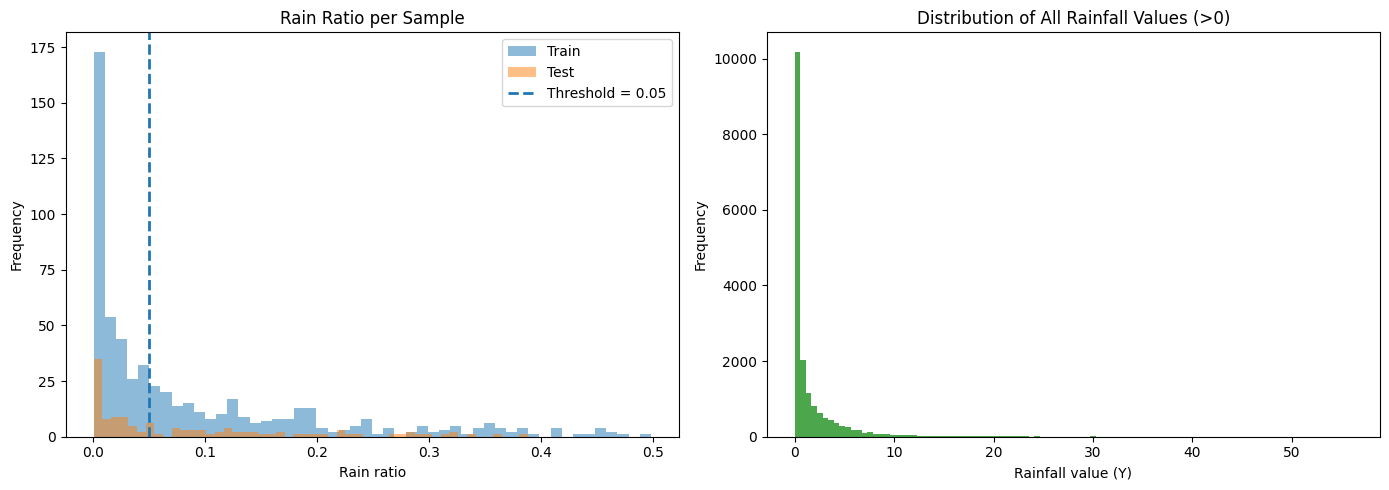

In [221]:
import numpy as np
import matplotlib.pyplot as plt

threshold_ratio = 0.05  # ngưỡng mưa

# Y_train, Y_test: shape (B, H, W)
datasets = {"Train": Y_train, "Test": Y[test_idx]}

# ===== Tính rain ratio cho train và test =====
rain_ratios_dict = {}
for name, Y in datasets.items():
    B, H, W = Y.shape
    total_pixels = H * W

    # rain ratio từng sample
    rain_ratios = np.array([
        np.sum(Y[i] > 0) / total_pixels
        for i in range(B)
    ])
    rain_ratios_dict[name] = rain_ratios

# ===== Lấy toàn bộ giá trị Y và chỉ giữ pixel >0 =====
Y_all = Y.reshape(-1)
Y_rain = Y_all[Y_all > 0]

# ===== Plot 2 subplot =====
plt.figure(figsize=(14, 5))

# (1) Rain ratio histogram train vs test
plt.subplot(1, 2, 1)
for name, ratios in rain_ratios_dict.items():
    plt.hist(ratios, bins=50, alpha=0.5, label=name)
plt.axvline(threshold_ratio, linestyle='--', linewidth=2, label='Threshold = 0.05')
plt.xlabel("Rain ratio")
plt.ylabel("Frequency")
plt.title("Rain Ratio per Sample")
plt.legend()

# (2) Rainfall values histogram tất cả pixel >0
plt.subplot(1, 2, 2)
plt.hist(Y_rain, bins=100, color='green', alpha=0.7)
plt.xlabel("Rainfall value (Y)")
plt.ylabel("Frequency")
plt.title("Distribution of All Rainfall Values (>0)")

plt.tight_layout()
plt.show()


# train unet

In [243]:
    BATCH_SIZE = 32
    EPOCHS = 30
    GRADIENT_ACCUMULATION = 1
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 5e-5
    GRADIENT_CLIP = 1.0

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

    model = Unet(n_channels=12, n_classes=1, bilinear=True)
    # model = Transformer()
    # model = CNN()
    criterion = RainfallLoss(mask_torch, mse_weight=0.7, mae_weight=0.3)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    total_updates = ((len(train_loader) + GRADIENT_ACCUMULATION - 1) // 
                     GRADIENT_ACCUMULATION) * EPOCHS
    
    scheduler = MyScheduler(
        optimizer, total_steps=total_updates,
        scheduler_type='cosine', warmup_ratio=0.03, final_lr_ratio=0.5
    )
    
    #model_path = 'best_model_dual_mask.pth'
    model_path_0 = 'unet.pth'
    # Trainer với dual masks
    
    trainer = Trainer(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler, 
        mask=mask,  # Mask cho Y (output)
        device=DEVICE, log_step=50, val_step=100,
        model_save_path= model_path_0,
        gradient_clip=GRADIENT_CLIP
    )

    trained_model, history_0 = trainer.train(
        num_epochs=EPOCHS,
        accumulate_steps=GRADIENT_ACCUMULATION,
        save_by='rmse'
    )


RainfallLoss initialized:
  Valid pixels: 887
  MSE weight: 0.7, MAE weight: 0.3
Y Mask shape: torch.Size([36, 49]), Valid pixels: 887

Model parameters:
  Total: 17,268,161
  Trainable: 17,268,161
✓ Best model saved (rmse=1.969517)

Epoch 1/30 Summary:
  Train Loss: 0.594396
  Val Loss: 0.692040
  RMSE: 1.9695 | MAE: 1.5515 | Pearson: 0.0053 | Spearman: -0.1769

✓ Best model saved (rmse=1.539561)

Epoch 2/30 Summary:
  Train Loss: 0.404752
  Val Loss: 0.404703
  RMSE: 1.5396 | MAE: 0.7016 | Pearson: 0.2133 | Spearman: -0.0493

✓ Best model saved (rmse=1.471371)

Epoch 3/30 Summary:
  Train Loss: 0.353013
  Val Loss: 0.360380
  RMSE: 1.4714 | MAE: 0.5269 | Pearson: 0.2393 | Spearman: 0.0075


Epoch 4/30 Summary:
  Train Loss: 0.356049
  Val Loss: 0.358874
  RMSE: 1.4752 | MAE: 0.5413 | Pearson: 0.2509 | Spearman: 0.0623


Epoch 5/30 Summary:
  Train Loss: 0.317138
  Val Loss: 0.372486
  RMSE: 1.5028 | MAE: 0.5347 | Pearson: 0.2736 | Spearman: 0.1151

✓ Best model saved (rmse=1.436388)

# train transformer

In [223]:
    BATCH_SIZE = 8
    EPOCHS = 30
    GRADIENT_ACCUMULATION = 1
    LEARNING_RATE = 5e-4
    WEIGHT_DECAY = 1e-4
    GRADIENT_CLIP = 1.0

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

    model = Transformer(H=Y.shape[1], W=Y.shape[2], dropout=0.00)
    # model = Transformer()
    # model = CNN()
    criterion = RainfallLoss(mask_torch, mse_weight=0.7, mae_weight=0.3)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    total_updates = ((len(train_loader) + GRADIENT_ACCUMULATION - 1) // 
                     GRADIENT_ACCUMULATION) * EPOCHS
    
    scheduler = MyScheduler(
        optimizer, total_steps=total_updates,
        scheduler_type='cosine', warmup_ratio=0.1, final_lr_ratio=0.5
    )
    
    #model_path = 'best_model_dual_mask.pth'
    model_path_1 = 'transformer.pth'
    # Trainer với dual masks
    
    trainer = Trainer(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler, 
        mask=mask,  # Mask cho Y (output)
        device=DEVICE, log_step=50, val_step=100,
        model_save_path= model_path_1,
        gradient_clip=GRADIENT_CLIP
    )

    trained_model, history_1 = trainer.train(
        num_epochs=EPOCHS,
        accumulate_steps=GRADIENT_ACCUMULATION,
        save_by='rmse'
    )


RainfallLoss initialized:
  Valid pixels: 887
  MSE weight: 0.7, MAE weight: 0.3
Y Mask shape: torch.Size([36, 49]), Valid pixels: 887

Model parameters:
  Total: 798,977
  Trainable: 798,977
Step 50	Loss: 0.504554	Grad: 2.8128	LR: 0.000115
✓ Best model saved (rmse=1.450093)

Epoch 1/30 Summary:
  Train Loss: 0.460800
  Val Loss: 0.361954
  RMSE: 1.4501 | MAE: 0.4363 | Pearson: 0.2878 | Spearman: 0.0365

Step 124	Loss: 0.428249	Grad: 11.2881	LR: 0.000282

Epoch 2/30 Summary:
  Train Loss: 0.459838
  Val Loss: 0.358036
  RMSE: 1.4703 | MAE: 0.5261 | Pearson: 0.2548 | Spearman: -0.0600

Step 198	Loss: 0.396312	Grad: 2.7655	LR: 0.000448

Epoch 3/30 Summary:
  Train Loss: 0.377317
  Val Loss: 0.369221
  RMSE: 1.4751 | MAE: 0.3949 | Pearson: 0.2450 | Spearman: 0.1745

Step 272	Loss: 0.371770	Grad: 0.6832	LR: 0.000500

Epoch 4/30 Summary:
  Train Loss: 0.357952
  Val Loss: 0.422873
  RMSE: 1.4872 | MAE: 0.3261 | Pearson: 0.2803 | Spearman: 0.1500

Step 346	Loss: 0.377249	Grad: 11.9068	LR: 0

# train cnn

In [224]:
    BATCH_SIZE = 32
    EPOCHS = 30
    GRADIENT_ACCUMULATION = 1
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 5e-5
    GRADIENT_CLIP = 1.0

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

    model = CNN()
    criterion = RainfallLoss(mask_torch, mse_weight=0.7, mae_weight=0.3)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    total_updates = ((len(train_loader) + GRADIENT_ACCUMULATION - 1) // 
                     GRADIENT_ACCUMULATION) * EPOCHS
    
    scheduler = MyScheduler(
        optimizer, total_steps=total_updates,
        scheduler_type='cosine', warmup_ratio=0.03, final_lr_ratio=0.5
    )
    
    #model_path = 'best_model_dual_mask.pth'
    model_path_2 = 'cnn.pth'
    # Trainer với dual masks
    
    trainer = Trainer(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler, 
        mask=mask,  # Mask cho Y (output)
        device=DEVICE, log_step=50, val_step=100,
        model_save_path= model_path_2,
        gradient_clip=GRADIENT_CLIP
    )

    trained_model, history_2 = trainer.train(
        num_epochs=EPOCHS,
        accumulate_steps=GRADIENT_ACCUMULATION,
        save_by='rmse'
    )


RainfallLoss initialized:
  Valid pixels: 887
  MSE weight: 0.7, MAE weight: 0.3
Y Mask shape: torch.Size([36, 49]), Valid pixels: 887

Model parameters:
  Total: 342,753
  Trainable: 342,753
✓ Best model saved (rmse=1.516433)

Epoch 1/30 Summary:
  Train Loss: 0.547371
  Val Loss: 0.495524
  RMSE: 1.5164 | MAE: 0.3075 | Pearson: 0.1952 | Spearman: 0.1125

✓ Best model saved (rmse=1.475603)

Epoch 2/30 Summary:
  Train Loss: 0.417809
  Val Loss: 0.398683
  RMSE: 1.4756 | MAE: 0.3863 | Pearson: 0.2217 | Spearman: 0.0899

✓ Best model saved (rmse=1.462814)

Epoch 3/30 Summary:
  Train Loss: 0.349841
  Val Loss: 0.385509
  RMSE: 1.4628 | MAE: 0.3995 | Pearson: 0.2453 | Spearman: 0.0425

✓ Best model saved (rmse=1.457844)

Epoch 4/30 Summary:
  Train Loss: 0.344588
  Val Loss: 0.364453
  RMSE: 1.4578 | MAE: 0.3978 | Pearson: 0.2515 | Spearman: 0.0456

✓ Best model saved (rmse=1.454051)

Epoch 5/30 Summary:
  Train Loss: 0.324133
  Val Loss: 0.373217
  RMSE: 1.4541 | MAE: 0.4041 | Pearson:

In [225]:
print(Y[0])

[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ...  0.  0. -0.]
 [-0. -0. -0. ...  0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


# Train mlp

In [226]:
    BATCH_SIZE = 8
    EPOCHS = 30
    GRADIENT_ACCUMULATION = 1
    LEARNING_RATE = 5e-4
    WEIGHT_DECAY = 1e-4
    GRADIENT_CLIP = 1.0

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

    model = MLP(H=Y.shape[1], W=Y.shape[2], dropout=0.00)
    # model = Transformer()
    # model = CNN()
    criterion = RainfallLoss(mask_torch, mse_weight=0.7, mae_weight=0.3)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    total_updates = ((len(train_loader) + GRADIENT_ACCUMULATION - 1) // 
                     GRADIENT_ACCUMULATION) * EPOCHS
    
    scheduler = MyScheduler(
        optimizer, total_steps=total_updates,
        scheduler_type='cosine', warmup_ratio=0.1, final_lr_ratio=0.5
    )
    
    #model_path = 'best_model_dual_mask.pth'
    model_path_3 = 'mlp.pth'
    # Trainer với dual masks
    
    trainer = Trainer(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler, 
        mask=mask,  # Mask cho Y (output)
        device=DEVICE, log_step=50, val_step=100,
        model_save_path= model_path_3,
        gradient_clip=GRADIENT_CLIP
    )

    trained_model, history_3 = trainer.train(
        num_epochs=EPOCHS,
        accumulate_steps=GRADIENT_ACCUMULATION,
        save_by='rmse'
    )


RainfallLoss initialized:
  Valid pixels: 887
  MSE weight: 0.7, MAE weight: 0.3
Y Mask shape: torch.Size([36, 49]), Valid pixels: 887

Model parameters:
  Total: 267,265
  Trainable: 267,265
Step 50	Loss: 0.528280	Grad: 2.0369	LR: 0.000115
✓ Best model saved (rmse=1.463293)

Epoch 1/30 Summary:
  Train Loss: 0.466915
  Val Loss: 0.347720
  RMSE: 1.4633 | MAE: 0.4109 | Pearson: 0.2385 | Spearman: -0.0431

Step 124	Loss: 0.394855	Grad: 1.7162	LR: 0.000282
✓ Best model saved (rmse=1.459545)

Epoch 2/30 Summary:
  Train Loss: 0.377738
  Val Loss: 0.343415
  RMSE: 1.4595 | MAE: 0.4103 | Pearson: 0.2456 | Spearman: 0.0313

Step 198	Loss: 0.341763	Grad: 0.4622	LR: 0.000448

Epoch 3/30 Summary:
  Train Loss: 0.343190
  Val Loss: 0.344828
  RMSE: 1.4602 | MAE: 0.3396 | Pearson: 0.2555 | Spearman: -0.0342

Step 272	Loss: 0.379684	Grad: 0.3657	LR: 0.000500

Epoch 4/30 Summary:
  Train Loss: 0.368798
  Val Loss: 0.354825
  RMSE: 1.4681 | MAE: 0.4468 | Pearson: 0.2549 | Spearman: 0.0129

Step 346

# ensemble

In [273]:
# ==================== TRAIN ENSEMBLE ====================
print("="*60)
print("TRAINING ENSEMBLE MODEL")
print("="*60)

# Load pre-trained models
test_model_0 = Unet(n_channels=12, n_classes=1, bilinear=True).to(DEVICE)
test_model_0.load_state_dict(torch.load("/kaggle/working/" + model_path_0, map_location=DEVICE)["model_state_dict"])

test_model_1 = Transformer(H=Y.shape[1], W=Y.shape[2], dropout=0.00).to(DEVICE)
test_model_1.load_state_dict(torch.load("/kaggle/working/" + model_path_1, map_location=DEVICE)["model_state_dict"])

test_model_2 = CNN().to(DEVICE)
test_model_2.load_state_dict(torch.load("/kaggle/working/" + model_path_2, map_location=DEVICE)["model_state_dict"])

test_model_3 = MLP(H=Y.shape[1], W=Y.shape[2], dropout=0.00).to(DEVICE)
test_model_3.load_state_dict(torch.load("/kaggle/working/" + model_path_3, map_location=DEVICE)["model_state_dict"])

base_models = [test_model_0, test_model_1, test_model_2, test_model_3]

# ==================== CHỌN ENSEMBLE METHOD ====================
# Option 1: Stacking - Meta-learner học combine predictions (RECOMMENDED)
# ensemble_model = StackingEnsemble(base_models, hidden_dim=32, freeze_base=True).to(DEVICE)

# Option 2: Attention - Weights khác nhau cho từng pixel
# ensemble_model = AttentionEnsemble(base_models, in_channels=12, freeze_base=True).to(DEVICE)

# Option 3: Gating - Chọn model tốt nhất theo global context
# ensemble_model = GatingEnsemble(base_models, in_channels=12, freeze_base=True).to(DEVICE)

# Option 4: Learned weights - Đơn giản nhưng tốt hơn fixed
ensemble_model = LearnedWeightEnsemble(base_models, freeze_base=True).to(DEVICE)

print(f"Ensemble type: {ensemble_model.__class__.__name__}")
print(f"Trainable params: {sum(p.numel() for p in ensemble_model.parameters() if p.requires_grad):,}")

# Training config for ensemble
ENSEMBLE_EPOCHS = 30
ENSEMBLE_LR = 1e-4
ENSEMBLE_BATCH = 8

ensemble_train_loader = DataLoader(train_dataset, batch_size=ENSEMBLE_BATCH, sampler=train_sampler)
criterion_ensemble = RainfallLoss(mask_torch, mse_weight=0.7, mae_weight=0.3)
optimizer_ensemble = optim.AdamW(
    filter(lambda p: p.requires_grad, ensemble_model.parameters()), 
    lr=ENSEMBLE_LR, 
    weight_decay=1e-4
)

total_steps = len(ensemble_train_loader) * ENSEMBLE_EPOCHS
scheduler_ensemble = torch.optim.lr_scheduler.OneCycleLR(
    optimizer_ensemble,
    max_lr=ENSEMBLE_LR * 4,
    total_steps=total_steps,
    pct_start=0.1,
    anneal_strategy='cos'
)

ensemble_path = 'ensemble_stacking.pth'

trainer_ensemble = Trainer(
    ensemble_model, ensemble_train_loader, val_loader,
    criterion_ensemble, optimizer_ensemble, scheduler_ensemble,
    mask=mask,
    device=DEVICE, log_step=50, val_step=100,
    model_save_path=ensemble_path,
    gradient_clip=1.0
)

ensemble_trained, ensemble_history = trainer_ensemble.train(
    num_epochs=ENSEMBLE_EPOCHS,
    accumulate_steps=1,
    save_by='rmse'
)

TRAINING ENSEMBLE MODEL
Ensemble type: LearnedWeightEnsemble
Trainable params: 6

RainfallLoss initialized:
  Valid pixels: 887
  MSE weight: 0.7, MAE weight: 0.3
Y Mask shape: torch.Size([36, 49]), Valid pixels: 887

Model parameters:
  Total: 18,677,162
  Trainable: 6
Step 50	Loss: 0.210483	Grad: 0.0934	LR: 0.000062
✓ Best model saved (rmse=1.358379)

Epoch 1/30 Summary:
  Train Loss: 0.210922
  Val Loss: 0.284990
  RMSE: 1.3584 | MAE: 0.3202 | Pearson: 0.4475 | Spearman: 0.0780

Step 124	Loss: 0.199484	Grad: 0.1345	LR: 0.000245

Epoch 2/30 Summary:
  Train Loss: 0.200654
  Val Loss: 0.285537
  RMSE: 1.3591 | MAE: 0.3126 | Pearson: 0.4471 | Spearman: 0.0742

Step 198	Loss: 0.208123	Grad: 0.0789	LR: 0.000390

Epoch 3/30 Summary:
  Train Loss: 0.208109
  Val Loss: 0.286503
  RMSE: 1.3591 | MAE: 0.3203 | Pearson: 0.4414 | Spearman: 0.0954

Step 272	Loss: 0.207833	Grad: 0.0397	LR: 0.000399
✓ Best model saved (rmse=1.358081)

Epoch 4/30 Summary:
  Train Loss: 0.210455
  Val Loss: 0.286098

Test Loss: 0.2732

TEST RESULTS (denormalized)
  RMSE: 1.3140
  MAE:  0.3652
  R²:   0.3203
  Pearson: 0.5780


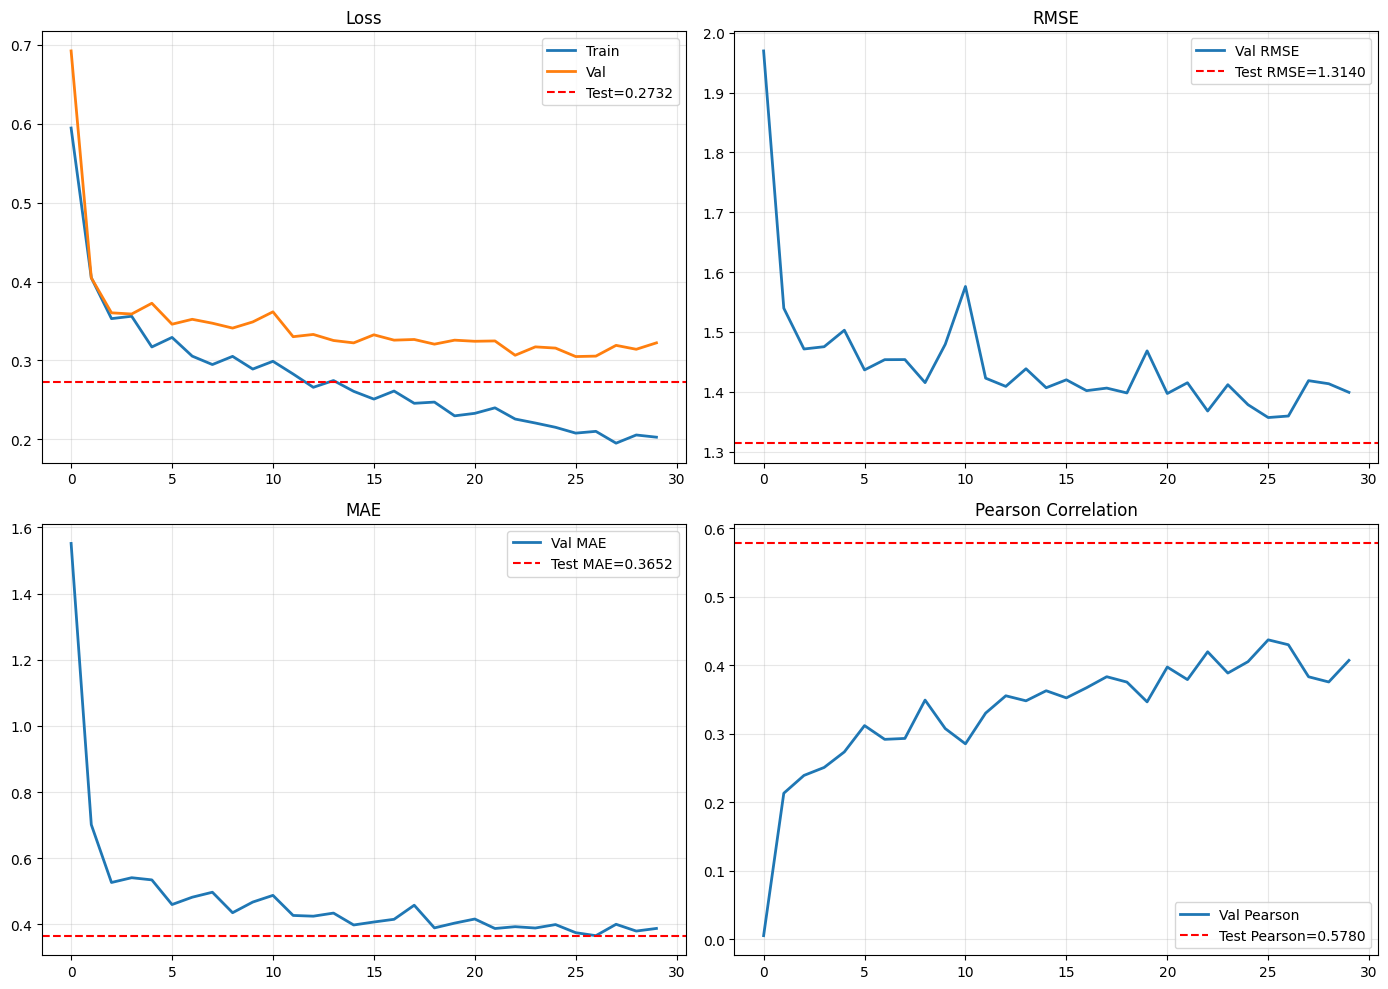


COMPARISON: Trained Ensemble vs Simple Average
  Simple Average RMSE: 1.3512
  Trained Ensemble RMSE: 1.3140
  Improvement: 2.76%

  Simple Average MAE: 0.3936
  Trained Ensemble MAE: 0.3652
  Improvement: 7.22%


In [274]:
# ------------------ RUN TEST ------------------
test_losses = []
all_pred_log = []
all_tgt_log = []

with torch.no_grad():
    for bx, by in test_loader:
        bx, by = bx.to(DEVICE), by.to(DEVICE)

        # ============ ENSEMBLE PREDICTION ============  
        out = ensemble_model(bx)  # (B, 1, H, W)
        out = out.squeeze(1)      # (B, H, W)

        loss = criterion(out, by)
        test_losses.append(loss.item())

        all_pred_log.append(out.cpu().numpy())
        all_tgt_log.append(by.cpu().numpy())

all_pred_log = np.concatenate(all_pred_log, axis=0)   # (N,H,W)
all_tgt_log = np.concatenate(all_tgt_log, axis=0)

test_pred_real = np.expm1(all_pred_log)  # (N,H,W)
test_tgt_real = np.expm1(all_tgt_log)

mean_test_loss = np.mean(test_losses)
print(f"Test Loss: {mean_test_loss:.4f}")

# ==================== SUMMARY METRICS ====================
print(f"\n{'='*60}")
print("TEST RESULTS (denormalized)")
print(f"{'='*60}")

pred_masked = test_pred_real[:, mask == 1]
target_masked = test_tgt_real[:, mask == 1]

test_mse = np.mean((pred_masked - target_masked)**2)
test_rmse = np.sqrt(test_mse)
test_mae = np.mean(np.abs(pred_masked - target_masked))
test_r2 = 1 - (np.sum((target_masked - pred_masked)**2) /
               np.sum((target_masked - np.mean(target_masked))**2))

# Pearson correlation
pred_flat = pred_masked.flatten()
target_flat = target_masked.flatten()
pearson_test = np.corrcoef(pred_flat, target_flat)[0, 1]

print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE:  {test_mae:.4f}")
print(f"  R²:   {test_r2:.4f}")
print(f"  Pearson: {pearson_test:.4f}")

# ==================== PLOTTING ====================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (1) Loss curves
axes[0, 0].plot(history_0['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(history_0['val_loss'], label='Val', linewidth=2)
axes[0, 0].axhline(y=mean_test_loss, color='red', linestyle='--',
                   label=f"Test={mean_test_loss:.4f}")
axes[0, 0].set_title("Loss")
axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)

# (2) RMSE
axes[0, 1].plot(history_0['val_rmse'], label='Val RMSE', linewidth=2)
axes[0, 1].axhline(y=test_rmse, color='red', linestyle='--',
                   label=f"Test RMSE={test_rmse:.4f}")
axes[0, 1].set_title("RMSE")
axes[0, 1].legend(); axes[0, 1].grid(True, alpha=0.3)

# (3) MAE
axes[1, 0].plot(history_0['val_mae'], label='Val MAE', linewidth=2)
axes[1, 0].axhline(y=test_mae, color='red', linestyle='--',
                   label=f"Test MAE={test_mae:.4f}")
axes[1, 0].set_title("MAE")
axes[1, 0].legend(); axes[1, 0].grid(True, alpha=0.3)

# (4) Pearson correlation
axes[1, 1].plot(history_0['val_corr'], label='Val Pearson', linewidth=2)
axes[1, 1].axhline(y=pearson_test, color='red', linestyle='--',
                   label=f"Test Pearson={pearson_test:.4f}")
axes[1, 1].set_title("Pearson Correlation")
axes[1, 1].legend(); axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==================== COMPARE WITH SIMPLE AVERAGE ====================
print(f"\n{'='*60}")
print("COMPARISON: Trained Ensemble vs Simple Average")
print(f"{'='*60}")

# Simple average
with torch.no_grad():
    simple_preds = []
    for bx, by in test_loader:
        bx = bx.to(DEVICE)
        outputs = [m(bx) for m in base_models]
        simple_avg = sum(outputs) / len(outputs)
        simple_preds.append(simple_avg.squeeze(1).cpu().numpy())

simple_pred_log = np.concatenate(simple_preds, axis=0)
simple_pred_real = np.expm1(simple_pred_log)
simple_masked = simple_pred_real[:, mask == 1]

simple_rmse = np.sqrt(np.mean((simple_masked - target_masked)**2))
simple_mae = np.mean(np.abs(simple_masked - target_masked))

print(f"  Simple Average RMSE: {simple_rmse:.4f}")
print(f"  Trained Ensemble RMSE: {test_rmse:.4f}")
print(f"  Improvement: {(simple_rmse - test_rmse) / simple_rmse * 100:.2f}%")
print()
print(f"  Simple Average MAE: {simple_mae:.4f}")
print(f"  Trained Ensemble MAE: {test_mae:.4f}")
print(f"  Improvement: {(simple_mae - test_mae) / simple_mae * 100:.2f}%")

# test


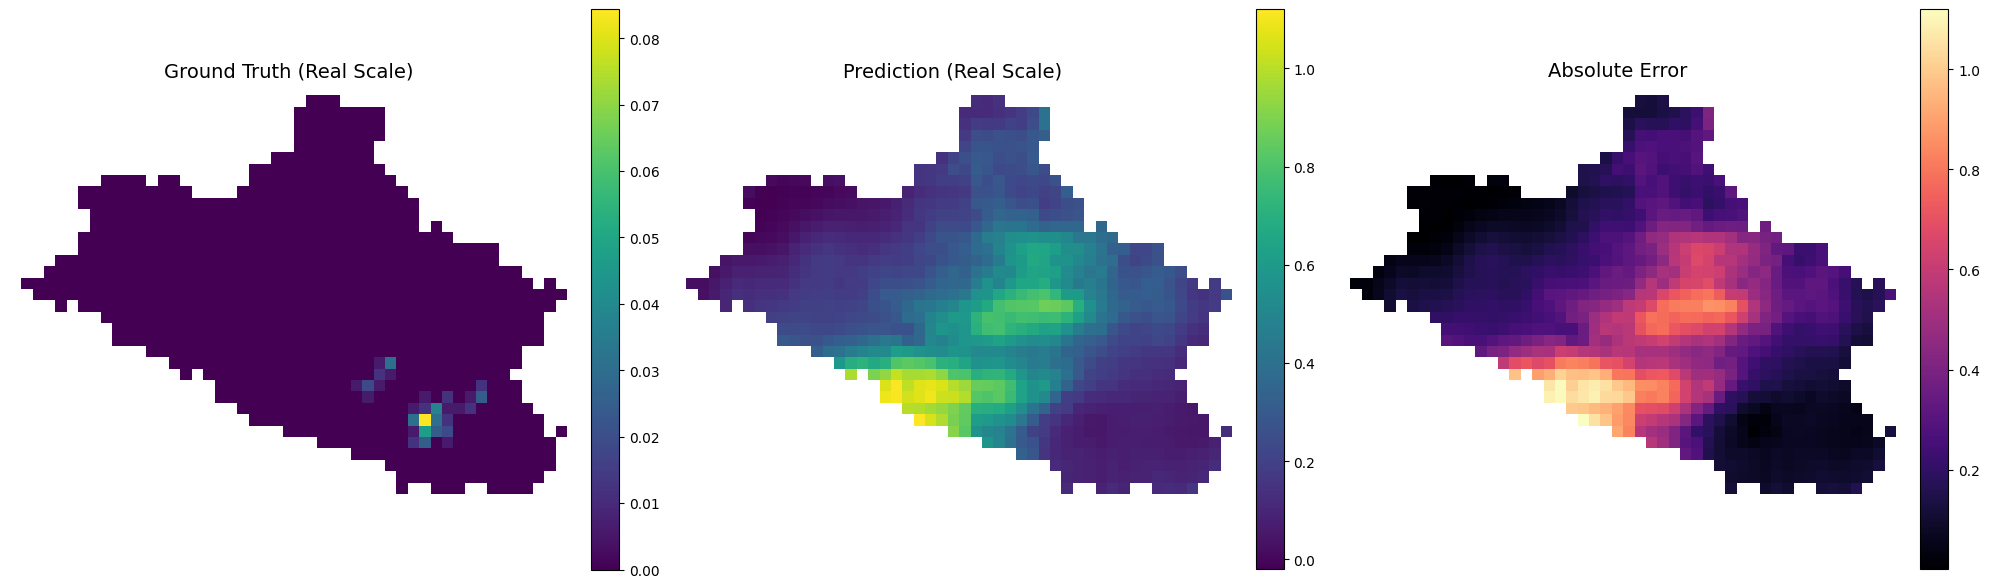

In [263]:
# ==================== FULL MAP VISUALIZATION ====================

import matplotlib.pyplot as plt
import numpy as np

# --------- CHỌN SAMPLE ---------
idx = 110  # đổi index nếu muốn xem sample khác

# --------- LẤY MAP (DENORMALIZED) ---------
gt_map = test_tgt_real[idx]     # (H, W)
pred_map = test_pred_real[idx]  # (H, W)

# --------- ÁP MASK (OPTIONAL) ---------
# Các pixel ngoài mask sẽ set = NaN để không hiển thị
gt_vis = gt_map.copy()
pred_vis = pred_map.copy()

gt_vis[mask != 1] = np.nan
pred_vis[mask != 1] = np.nan

# --------- VẼ FULL MAP ---------
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- Ground Truth ---
im0 = axes[0].imshow(gt_vis, cmap="viridis")
axes[0].set_title("Ground Truth (Real Scale)", fontsize=14)
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# --- Prediction ---
im1 = axes[1].imshow(pred_vis, cmap="viridis")
axes[1].set_title("Prediction (Real Scale)", fontsize=14)
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# --- Absolute Error ---
err_vis = np.abs(pred_vis - gt_vis)
im2 = axes[2].imshow(err_vis, cmap="magma")
axes[2].set_title("Absolute Error", fontsize=14)
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()